In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [9]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [10]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [12]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

## Load unpacked features data

In [303]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
filename = 'Features_AllLocsHP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [304]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [305]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [306]:
# #drop features 
# Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
# Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [74]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [75]:
Dataorig = Data.copy()
Data.shape

(40377, 63)

In [76]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

## LOSO CV - ALL TASKS

## Bradykinesia

In [30]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [160]:
Dataorig = Data.copy()

In [161]:
Dataorig[symptom].unique()

array([  0.,   1.,  nan,   2.,   3.,   4.])

In [162]:
Data[symptom].unique()

array([  0.,   1.,  nan,   2.,   3.,   4.])

In [297]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16682/32592 = 0.51
Training Random Forest

Subj/Visit 0, prec=0.537, rec=0.546, Spec=0.764, auroc_train=1.000, auroc=0.717

Subj/Visit 1, prec=0.952, rec=0.747, Spec=0.595, auroc_train=1.000, auroc=0.730

Subj/Visit 2, prec=0.760, rec=0.765, Spec=0.682, auroc_train=1.000, auroc=0.788

Subj/Visit 3, prec=0.467, rec=0.934, Spec=0.575, auroc_train=1.000, auroc=0.859

Subj/Visit 4, prec=0.484, rec=0.574, Spec=0.431, auroc_train=1.000, auroc=0.516

Subj/Visit 5, prec=0.799, rec=0.594, Spec=0.749, auroc_train=1.000, auroc=0.746

Subj/Visit 6, prec=0.602, rec=0.624, Spec=0.409, auroc_train=1.000, auroc=0.531

Subj/Visit 7, prec=0.646, rec=0.777, Spec=0.603, auroc_train=1.000, auroc=0.784

Subj/Visit 8, prec=0.875, rec=0.641, Spec=0.438, auroc_train=1.000, auroc=0.524

Subj/Visit 9, prec=0.309, rec=0.534, Spec=0.537, auroc_train=1.000, auroc=0.547

Subj/Visit 10, prec=0.663, rec=0.809, Spec=0.599, auroc_train=1.000, auroc=0.763

Subj/Visit 11, prec=0.578, rec=0.568, Spec=0.

In [289]:
resultsbrady = res_group['Random Forest']['auroc']

In [292]:
np.save('./Results/resultsbradyLOSO.npy',resultsbrady)

In [79]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1047, 1049, 1051, 1052, 1053, 1054, 1055, 1056])

Removing nans

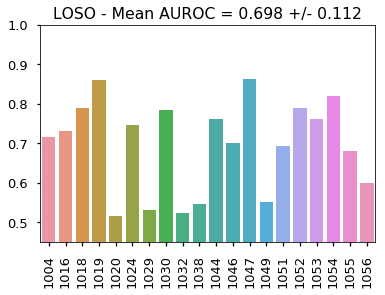

In [300]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

### Tremor

In [307]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.353, rec=0.346, Spec=0.932, auroc_train=1.000, auroc=0.810

Subj/Visit 1, prec=0.746, rec=0.106, Spec=0.970, auroc_train=1.000, auroc=0.759

Subj/Visit 2, prec=0.694, rec=0.364, Spec=0.984, auroc_train=1.000, auroc=0.816

Subj/Visit 3, prec=0.163, rec=0.355, Spec=0.916, auroc_train=1.000, auroc=0.712

Subj/Visit 4, prec=0.556, rec=0.431, Spec=0.906, auroc_train=1.000, auroc=0.757

Subj/Visit 5, prec=0.505, rec=0.085, Spec=0.971, auroc_train=1.000, auroc=0.685

Subj/Visit 6, prec=0.677, rec=0.373, Spec=0.882, auroc_train=1.000, auroc=0.737

Subj/Visit 7, prec=0.750, rec=0.415, Spec=0.991, auroc_train=1.000, auroc=0.913

Subj/Visit 8, prec=0.704, rec=0.365, Spec=0.994, auroc_train=1.000, auroc=0.915

Subj/Visit 9, prec=0.951, rec=0.288, Spec=0.981, auroc_train=1.000, auroc=0.789

Subj/Visit 10, prec=0.200, rec=0.362, Spec=0.945, auroc_train=1.000, auroc=0.896

Subj/Visit 11, prec=0.552, rec=0.208, Spec=0.957, au

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.977, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.030, rec=0.167, Spec=0.963, auroc_train=1.000, auroc=0.868

Subj/Visit 18, prec=0.941, rec=0.147, Spec=0.960, auroc_train=1.000, auroc=0.612

Subj/Visit 19, prec=0.909, rec=0.323, Spec=0.903, auroc_train=1.000, auroc=0.712
f1_test=0.303+/-0.185, prec=0.488+/-0.323, rec=0.278+/-0.152, auprc=0.446+/-0.289, auroc=0.778+/-0.084
Elapsed time = 5.075 min


In [309]:
resultstremor = res_group['Random Forest']['auroc']

In [310]:
np.save('./Results/resultstremorLOSO.npy',resultstremor)

Removing nans

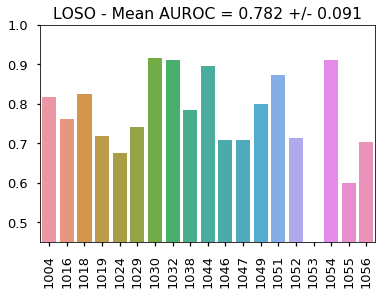

In [13]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Evaluate performance of global models on Subtasks (this section has to be rewritten to train global and personal models on all tasks and analyze performance on each subset of tasks)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Tremor 1333/3187 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.757, rec=0.812, Spec=0.926, auroc_train=1.000, auroc=0.923

Subj/Visit 1, prec=0.768, rec=0.495, Spec=0.698, auroc_train=1.000, auroc=0.648

Subj/Visit 2, prec=0.802, rec=0.901, Spec=0.778, auroc_train=1.000, auroc=0.930

Subj/Visit 3, prec=0.562, rec=0.800, Spec=0.776, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.775, rec=0.392, Spec=0.892, auroc_train=1.000, auroc=0.683

Subj/Visit 5, prec=0.717, rec=0.804, Spec=0.460, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=0.949, rec=0.825, Spec=0.922, auroc_train=1.000, auroc=0.939

Subj/Visit 7, prec=0.521, rec=0.700, Spec=0.408, auroc_train=1.000, auroc=0.566

Subj/Visit 8, prec=0.894, rec=0.596, Spec=0.389, auroc_train=1.000, auroc=0.405

Subj/Visit 9, prec=0.758, rec=0.625, Spec=0.830, auroc_train=1.000, auroc=0.838

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.0

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.286, rec=0.833, Spec=0.781, auroc_train=1.000, auroc=0.875

Subj/Visit 17, prec=1.000, rec=0.328, Spec=1.000, auroc_train=1.000, auroc=0.751

Subj/Visit 18, prec=0.979, rec=0.354, Spec=0.958, auroc_train=1.000, auroc=0.747
f1_test=0.504+/-0.281, prec=0.570+/-0.336, rec=0.512+/-0.297, auprc=0.631+/-0.302, auroc=0.750+/-0.150

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Tremor 895/6673 = 0.13
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.124


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.322, Spec=1.000, auroc_train=1.000, auroc=0.945


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.631, rec=0.745, Spec=0.932, auroc_train=1.000, auroc=0.950


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.804

Subj/Visit 18, prec=0.992, rec=0.510, Spec=0.987, auroc_train=1.000, auroc=0.799
f1_test=0.099+/-0.226, prec=0.191+/-0.376, rec=0.084+/-0.203, auprc=0.678+/-0.362, auroc=0.709+/-0.282

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Tremor 3714/12167 = 0.31
Training Random Forest

Subj/Visit 0, prec=0.421, rec=0.232, Spec=0.935, auroc_train=1.000, auroc=0.707

Subj/Visit 1, prec=0.894, rec=0.063, Spec=0.952, auroc_train=1.000, auroc=0.531

Subj/Visit 2, prec=0.167, rec=0.087, Spec=0.938, auroc_train=1.000, auroc=0.555

Subj/Visit 3, prec=0.028, rec=0.042, Spec=0.948, auroc_train=1.000, auroc=0.509

Subj/Visit 4, prec=0.569, rec=0.120, Spec=0.947, auroc_train=1.000, auroc=0.587

Subj/Visit 5, prec=0.744, rec=0.450, Spec=0.780

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=1.000, rec=0.237, Spec=1.000, auroc_train=1.000, auroc=0.731


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.930, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.504


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.691, rec=0.506, Spec=0.748, auroc_train=1.000, auroc=0.672


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.913, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.365, rec=0.342, Spec=0.909, auroc_train=1.000, auroc=0.728


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.957, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.176, Spec=0.821, auroc_train=1.000, auroc=0.430

Subj/Visit 18, prec=0.879, rec=0.269, Spec=0.867, auroc_train=1.000, auroc=0.624
f1_test=0.176+/-0.199, prec=0.348+/-0.376, rec=0.133+/-0.159, auprc=0.481+/-0.343, auroc=0.569+/-0.151

 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Tremor 2227/10303 = 0.22
Training Random Forest

Subj/Visit 0, prec=0.241, rec=0.140, Spec=0.955, auroc_train=1.000, auroc=0.782

Subj/Visit 1, prec=0.905, rec=0.083, Spec=0.994, auroc_train=1.000, auroc=0.805

Subj/Visit 2, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.823


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.364, rec=0.019, Spec=0.982, auroc_train=1.000, auroc=0.667

Subj/Visit 5, prec=0.658, rec=0.200, Spec=0.922, auroc_train=1.000, auroc=0.676


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.807

Subj/Visit 8, prec=0.963, rec=0.270, Spec=0.980, auroc_train=1.000, auroc=0.845


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=0.418


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.699, rec=0.657, Spec=0.768, auroc_train=1.000, auroc=0.777


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.133, rec=0.051, Spec=0.967, auroc_train=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.968, rec=0.276, Spec=0.975, auroc_train=1.000, auroc=0.789

Subj/Visit 18, prec=0.915, rec=0.328, Spec=0.942, auroc_train=1.000, auroc=0.780
f1_test=0.153+/-0.204, prec=0.360+/-0.409, rec=0.111+/-0.167, auprc=0.501+/-0.320, auroc=0.730+/-0.119


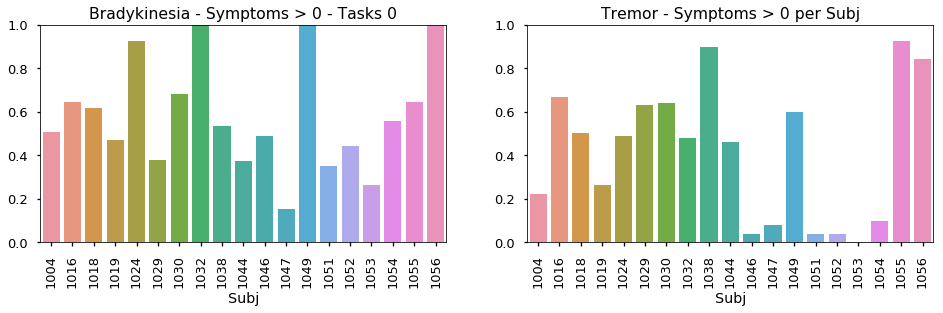

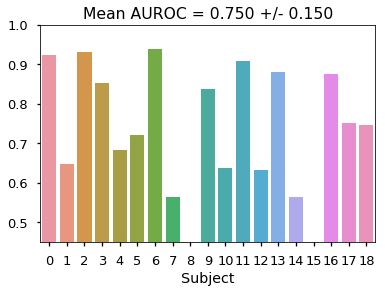

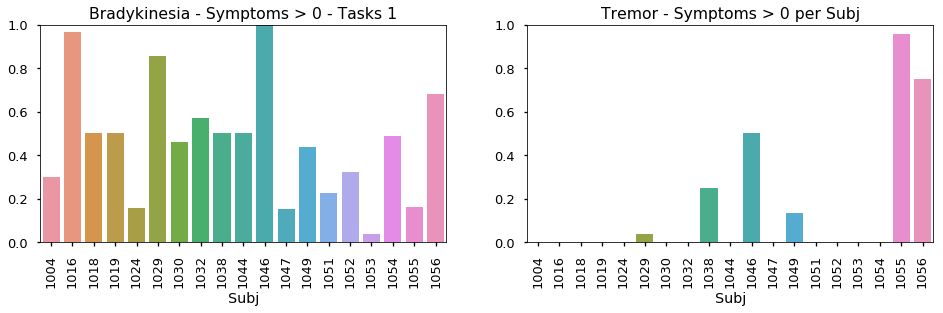

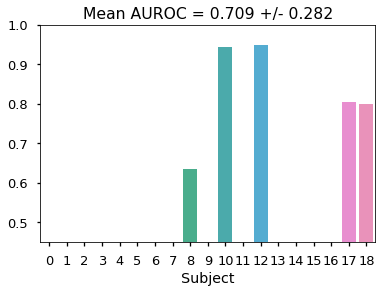

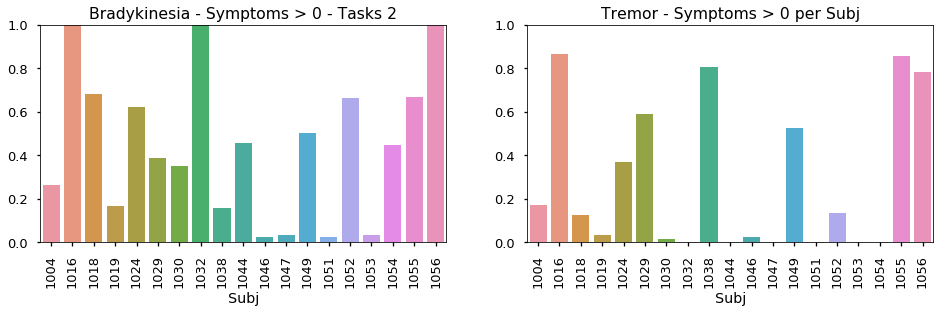

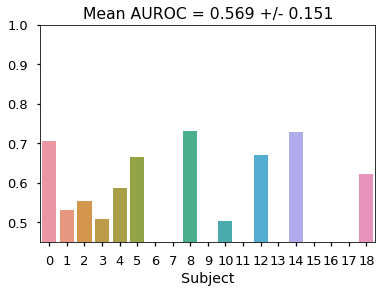

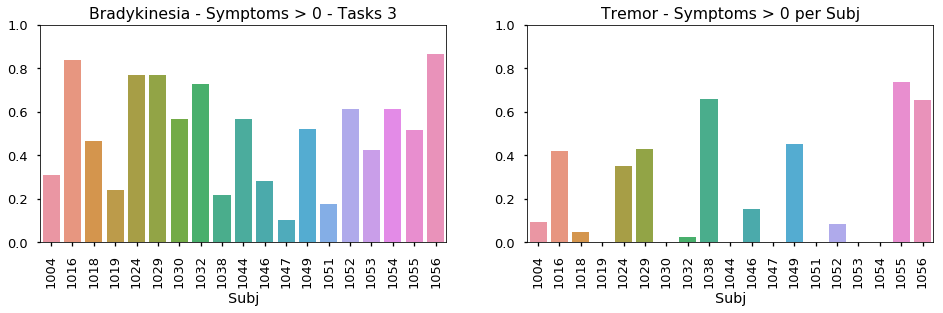

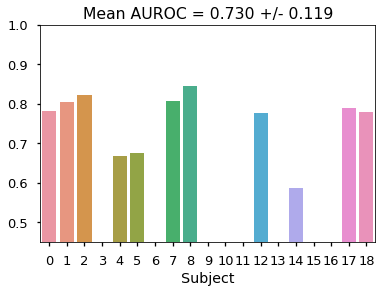

In [146]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on each subject
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


# Effect of # of subjects

In [132]:
# #if want to use only the selected features (to speed up)
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

### Bradykinesia

In [163]:
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

In [167]:
symptom

'Bradykinesia'

In [168]:
#sample p subjects at random for train and test on 1 random remaining subject

results = pd.DataFrame()
subjs=Data.Subject.unique()
nsubj = [4,6,8,12,16] #of subjects to train on
clf = RandomForestClassifier(n_estimators=50,random_state=2)
auc_all={}
testsublist = []
t1=time.time()

for iteration in range(500):
    

    trainsubjall = np.random.choice(subjs,size=16,replace=False) #sample 16 subjects at random
    
    #pick a test subject at random
    losubjs = Data[~Data.Subject.isin(trainsubjall)].Subject.unique()
    testsubj = np.random.choice(losubjs)
    dtest = Data[Data.Subject==testsubj]
    testsublist.append(testsubj)
    
    #use top features
    Xte = dtest.iloc[:,7:].as_matrix()
#     Xte = dtest[topf].as_matrix()
    yte = (dtest[symptom]>0).values.astype(int)

    if iteration%10==0:
        print(iteration,trainsubjall,testsubj)

    #compute and store AUC for an incremental number of train subjects tested on the left out subject
    for NS in nsubj:
    
        trainsubj = trainsubjall[:NS] #add subjects incrementally each time
        dtrain = Data[Data.Subject.isin(trainsubj)]

        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)

        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auc_all.update({NS:auroc}) #store auc for each grp


    results=pd.concat((results,pd.DataFrame(auc_all,index=[iteration])))
    


#     results.update({ng:auc_all}) #save auc for all runs for each group
print('elapsed %.3f min'%((time.time()-t1)/60))


0 [1032 1056 1052 1029 1016 1038 1004 1054 1019 1018 1053 1047 1030 1020 1044
 1024] 1046
10 [1052 1038 1049 1019 1047 1054 1051 1030 1020 1032 1046 1044 1029 1016 1004
 1024] 1053
20 [1049 1056 1055 1029 1044 1038 1047 1004 1024 1018 1020 1032 1053 1051 1019
 1054] 1016
30 [1019 1016 1044 1024 1053 1038 1051 1004 1030 1018 1052 1029 1032 1056 1047
 1054] 1046
40 [1056 1052 1047 1055 1053 1024 1029 1054 1049 1004 1030 1016 1020 1051 1032
 1019] 1018
50 [1053 1051 1052 1055 1019 1038 1032 1056 1016 1046 1054 1029 1049 1024 1020
 1004] 1018
60 [1016 1029 1030 1056 1024 1018 1004 1046 1049 1051 1038 1055 1052 1053 1044
 1032] 1019
70 [1020 1018 1053 1029 1054 1038 1055 1052 1004 1047 1016 1032 1019 1030 1049
 1024] 1051
80 [1038 1029 1004 1016 1024 1019 1030 1020 1056 1018 1032 1052 1051 1044 1049
 1047] 1053
90 [1024 1029 1054 1038 1052 1044 1018 1053 1055 1049 1046 1019 1047 1030 1004
 1056] 1020
100 [1044 1047 1018 1053 1052 1032 1054 1024 1030 1038 1016 1049 1019 1029 1020
 1056] 1051

In [170]:
results.to_csv('SimsMultiSubj_Brady.csv')

In [171]:
np.save('SimsMultiSubj_testsublist_brady.npy',testsublist)

Bradykinesia Results

In [270]:
results=pd.read_csv('SimsMultiSubj_Brady.csv',index_col=False)
results=results.drop('Unnamed: 0',axis=1)

In [271]:
results2=results.iloc[:,1:].copy()

In [272]:
baseline = results.iloc[:,0].copy()

In [273]:
diffs = results2.apply(lambda x:x - baseline)

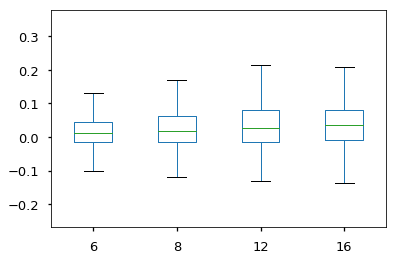

In [274]:
diffs.plot(kind='box')

-0.0791147729506 0.132757622925
-0.0966322374058 0.153694321298
-0.0943197229707 0.173267278522
-0.112794756692 0.192318924207


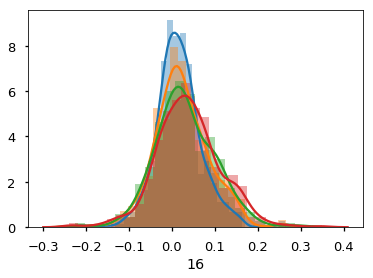

In [214]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [276]:
diffs['TestSubj']= testsublist

In [2]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='6',data=diffs)

In [3]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='16',data=diffs)

In [268]:
a.shape

(500,)

### Tremor Results

In [237]:
results=pd.read_csv('SimsMultiSubj_Tremor.csv',index_col=False)

In [238]:
results=results.drop('Unnamed: 0',axis=1)

In [239]:
results=results.dropna()

In [240]:
results2=results.iloc[:,1:].copy()

In [241]:
baseline = results.iloc[:,0].copy()

In [242]:
diffs = results2.apply(lambda x:x - baseline)

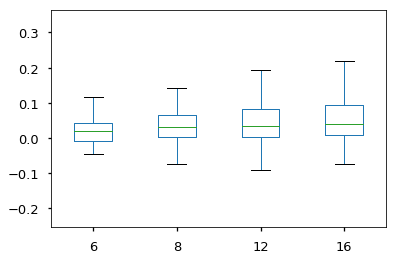

In [243]:
diffs.plot(kind='box')

-0.116055849322 0.177949411558
-0.0691723836327 0.186991451785
-0.0855872511339 0.181640949656
-0.0657825338663 0.214298338209


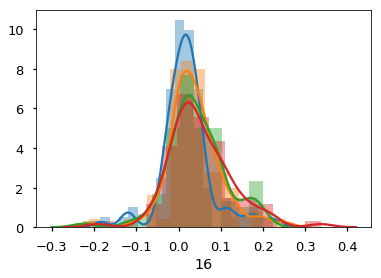

In [248]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [255]:
Xtr.shape

(25552, 56)

In [1]:
# y=np.asarray(diffs)
# x = diffs.columns.values
# sns.tsplot(y,x,ci='sd')

## Personal Models

In [42]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.794, rec=0.222, Spec=0.548, auroc_train=1.000, auroc=0.474

Subj/Visit 1, prec=0.281, rec=0.257, Spec=0.876, auroc_train=1.000, auroc=0.671

Subj/Visit 2, prec=0.478, rec=0.458, Spec=0.940, auroc_train=1.000, auroc=0.908

Subj/Visit 3, prec=0.589, rec=0.644, Spec=0.727, auroc_train=1.000, auroc=0.766

Subj/Visit 4, prec=0.442, rec=0.885, Spec=0.849, auroc_train=1.000, auroc=0.884

Subj/Visit 5, prec=0.688, rec=0.478, Spec=0.943, auroc_train=1.000, auroc=0.900

Subj/Visit 6, prec=0.564, rec=0.595, Spec=0.762, auroc_train=1.000, auroc=0.770
f1_test=0.490+/-0.125, prec=0.548+/-0.155, rec=0.506+/-0.212, auprc=0.549+/-0.202, auroc=0.768+/-0.144
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.984, rec=0.984, Spec=0.714, auroc_train=1.000, auroc=0.976

Subj/Visit 1, prec=0.955, rec=1.000, Spec=0.633, auroc_train=1.000, auroc=0.991

Subj/Visit 2, prec=0.945, rec=1.000, Spec=0.536, auroc_train=1.000, auroc=0.992

Subj/Visit 3, 

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.791, rec=0.738, Spec=0.768, auroc_train=1.000, auroc=0.821

Subj/Visit 1, prec=0.842, rec=0.830, Spec=0.812, auroc_train=1.000, auroc=0.857

Subj/Visit 2, prec=0.801, rec=0.842, Spec=0.746, auroc_train=1.000, auroc=0.885

Subj/Visit 3, prec=0.901, rec=0.694, Spec=0.904, auroc_train=1.000, auroc=0.882

Subj/Visit 4, prec=0.822, rec=0.811, Spec=0.793, auroc_train=1.000, auroc=0.889

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.805

Subj/Visit 6, prec=0.472, rec=0.482, Spec=0.469, auroc_train=1.000, auroc=0.467
f1_test=0.752+/-0.115, prec=0.773+/-0.128, rec=0.735+/-0.115, auprc=0.829+/-0.134, auroc=0.801+/-0.140
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.8

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.963+/-0.031, prec=0.935+/-0.057, rec=0.994+/-0.009, auprc=0.989+/-0.012, auroc=0.935+/-0.040


In [51]:
Data.shape

(32368, 63)

In [46]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

(0.45, 1)

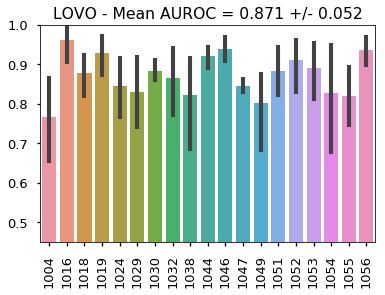

In [48]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [31]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


Subject 1004
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.013, Spec=1.000, auroc_train=1.000, auroc=0.704


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.714, rec=0.294, Spec=0.992, auroc_train=1.000, auroc=0.778
f1_test=0.206+/-0.354, prec=0.388+/-0.456, rec=0.187+/-0.347, auprc=0.725+/-0.243, auroc=0.827+/-0.126
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.829, rec=0.784, Spec=0.851, auroc_train=1.000, auroc=0.908

Subj/Visit 1, prec=0.892, rec=0.866, Spec=0.876, auroc_train=1.000, auroc=0.940

Subj/Visit 2, prec=0.930, rec=0.816, Spec=0.929, auroc_train=1.000, auroc=0.962

Subj/Visit 3, prec=0.914, rec=0.886, Spec=0.912, auroc_train=1.000, auroc=0.963

Subj/Visit 4, prec=0.942, rec=0.902, Spec=0.933, auroc_train=1.000, auroc=0.972

Subj/Visit 5, prec=0.935, rec=0.832, Spec=0.921, auroc_train=1.000, auroc=0.951


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.460, auroc_train=1.000, auroc=nan
f1_test=0.751+/-0.308, prec=0.777+/-0.319, rec=0.727+/-0.299, auprc=0.946+/-0.032, auroc=0.949+/-0.021
Subject 1018
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.127, Spec=1.000, auroc_train=1.000, auroc=0.753

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.909, Spec=1.000, auroc_train=1.000, auroc=0.998

Subj/Visit 3, prec=1.000, rec=0.324, Spec=1.000, auroc_train=1.000, auroc=0.850

Subj/Visit 4, prec=1.000, rec=0.279, Spec=1.000, auroc_train=1.000, auroc=0.800

Subj/Visit 5, prec=1.000, rec=0.750, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.867, rec=1.000, Spec=0.993, auroc_train=1.000, auroc=0.999
f1_test=0.699+/-0.285, prec=0.981+/-0.047, rec=0.627+/-0.346, auprc=0.803+/-0.212, auroc=0.914+/-0.101
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.526

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=0.821

Subj/Visit 4, prec=1.000, rec=0.667, Spec=1.000, auroc_train=1.000, auroc=0.999

Subj/Visit 5, prec=1.000, rec=0.667, Spec=1.000, auroc_train=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.714
f1_test=0.467+/-0.414, prec=0.571+/-0.495, rec=0.405+/-0.376, auprc=0.679+/-0.366, auroc=0.866+/-0.174
Subject 1024
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.083, Spec=1.000, auroc_train=1.000, auroc=0.831

Subj/Visit 1, prec=0.345, rec=0.312, Spec=0.925, auroc_train=1.000, auroc=0.833

Subj/Visit 2, prec=0.116, rec=0.833, Spec=0.860, auroc_train=1.000, auroc=0.914

Subj/Visit 3, prec=0.875, rec=0.126, Spec=0.979, auroc_train=1.000, auroc=0.713

Subj/Visit 4, prec=0.650, rec=0.394, Spec=0.971, auroc_train=1.000, auroc=0.915

Subj/Visit 5, prec=0.074, rec=0.333, Spec=0.912, auroc_train=1.000, auroc=0.833

Subj/Visit 6, prec=0.644, rec=0.558, Spec=0.936, auroc_train=1.000, auroc=0.855
f1_test=0.302+/-0.167, prec=0.529+/-0.334, rec=0.377+/-0.238, auprc=0.485+/-0.293, auroc=0.842+/-0.063
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.339, Spec=1.000, auroc_train=1.000, auroc

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.996
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.993
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.904+/-0.005, auroc=0.994+/-0.001
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.842, rec=0.700, Spec=0.810, auroc_train=1.000, auroc=0.839

Subj/Visit 1, prec=0.827, rec=0.821, Spec=0.869, auroc_train=1.000, auroc=0.904

Subj/Visit 2, prec=0.750, rec=0.771, Spec=0.816, auroc_train=1.000, auroc=0.891

Subj/Visit 3, prec=0.820, rec=0.446, Spec=0.952, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.744, rec=0.874, Spec=0.871, auroc_train=1.000, auroc=0.927

Subj/Visit 5, prec=0.773, rec=0.667, Spec=0.848, auroc_train=1.000, auroc=0.868

Subj/Visit 6, prec=0.769, rec=0.609, Spec=0.824, auroc_train=1.000, auroc=0.794
f1_test=0.732+/-0.078, prec=0.789+/-0.037, rec=0.698+/-0.133, auprc=0.825+/-0.059, auroc=0.867+/-0.042
Subject 1051
Training Random Forest
only 1 class in test da

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.610


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=0.770


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:90: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:91: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.345+/-0.114, auroc=0.690+/-0.080
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.955, rec=0.943, Spec=0.083, auroc_train=1.000, auroc=0.810

Subj/Visit 1, prec=0.626, rec=0.945, Spec=0.148, auroc_train=1.000, auroc=0.610

Subj/Visit 2, prec=0.688, rec=0.972, Spec=0.170, auroc_train=1.000, auroc=0.691

Subj/Visit 3, prec=0.937, rec=0.937, Spec=0.444, auroc_train=1.000, auroc=0.888

Subj/Visit 4, prec=0.826, rec=0.986, Spec=0.167, auroc_train=1.000, auroc=0.741

Subj/Visit 5, prec=0.991, rec=0.906, Spec=0.000, auroc_train=1.000, auroc=0.474
f1_test=0.882+/-0.076, prec=0.837+/-0.138, rec=0.948+/-0.026, auprc=0.895+/-0.114, auroc=0.702+/-0.134
Subject 1056
Tra

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.886, rec=0.981, Spec=0.000, auroc_train=1.000, auroc=0.665
f1_test=0.802+/-0.198, prec=0.756+/-0.282, rec=0.947+/-0.053, auprc=0.804+/-0.247, auroc=0.699+/-0.082


In [67]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.45, 1.0)

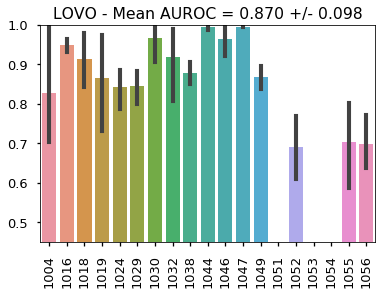

In [70]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [25]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc,rangeYacc,rangeZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.599504,0.744752,0.483158,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.535280,0.693556,0.445568,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


Train on 1 session

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.200, rec=0.972, Spec=0.052, auroc_train=1.000, auroc=0.435

Subj/Visit 1, prec=0.333, rec=0.045, Spec=0.949, auroc_train=1.000, auroc=0.604

Subj/Visit 2, prec=0.647, rec=0.050, Spec=0.983, auroc_train=1.000, auroc=0.704

Subj/Visit 3, prec=0.428, rec=0.278, Spec=0.823, auroc_train=1.000, auroc=0.690

Subj/Visit 4, prec=0.828, rec=0.055, Spec=0.993, auroc_train=1.000, auroc=0.621

Subj/Visit 5, prec=0.526, rec=0.198, Spec=0.901, auroc_train=1.000, auroc=0.695
f1_test=0.205+/-0.115, prec=0.494+/-0.205, rec=0.266+/-0.328, auprc=0.460+/-0.102, auroc=0.625+/-0.093
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.940, rec=0.997, Spec=0.412, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.970, rec=0.958, Spec=0.687, auroc_train=1.000, auroc=0.879

Subj/Visit 2, prec=0.973, rec=0.956, Spec=0.718, auroc_train=1.000, auroc=0.904

Subj/Visit 3, prec=0.938, rec=0.990, Spec=0.409, auroc_train=1.000, auroc=0.

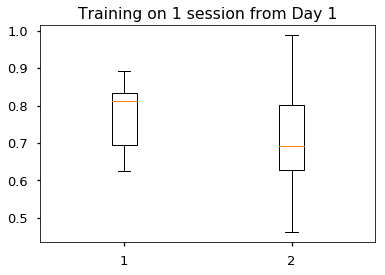

In [64]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2

ax=plt.boxplot([day1_1.values, auroc2_1])
plt.title('Training on 1 session from Day 1')

    


Train on 5 sessions

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.696, rec=0.132, Spec=0.548, auroc_train=1.000, auroc=0.454

Subj/Visit 1, prec=0.294, rec=0.286, Spec=0.870, auroc_train=1.000, auroc=0.673

Subj/Visit 2, prec=0.625, rec=0.625, Spec=0.955, auroc_train=1.000, auroc=0.919

Subj/Visit 3, prec=0.578, rec=0.678, Spec=0.699, auroc_train=1.000, auroc=0.743

Subj/Visit 4, prec=0.379, rec=0.846, Spec=0.812, auroc_train=1.000, auroc=0.913

Subj/Visit 5, prec=0.724, rec=0.457, Spec=0.955, auroc_train=1.000, auroc=0.894
f1_test=0.474+/-0.160, prec=0.549+/-0.159, rec=0.504+/-0.242, auprc=0.596+/-0.179, auroc=0.766+/-0.167
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.988, rec=0.972, Spec=0.786, auroc_train=1.000, auroc=0.975

Subj/Visit 1, prec=0.971, rec=0.996, Spec=0.767, auroc_train=1.000, auroc=0.989

Subj/Visit 2, prec=0.953, rec=1.000, Spec=0.607, auroc_train=1.000, auroc=0.996

Subj/Visit 3, prec=1.000, rec=0.954, Spec=1.000, auroc_train=1.000, auroc=0.

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.862


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan
f1_test=0.184+/-0.262, prec=0.297+/-0.425, rec=0.133+/-0.189, auprc=0.768+/-0.024, auroc=0.845+/-0.016
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.796, rec=0.738, Spec=0.775, auroc_train=1.000, auroc=0.841

Subj/Visit 1, prec=0.849, rec=0.837, Spec=0.821, auroc_train=1.000, auroc=0.888

Subj/Visit 2, prec=0.791, rec=0.861, Spec=0.723, auroc_train=1.000, auroc=0.898

Subj/Visit 3, prec=0.890, rec=0.720, Spec=0.888, auroc_train=1.000, auroc=0.878

Subj/Visit 4, prec=0.840, rec=0.862, Spec=0.807, auroc_train=1.000, auroc=0.916

Subj/Visit 5, prec=0.780, rec=0.748, Spec=0.744, auroc_train=1.000, auroc=0.814
f1_test=0.807+/-0.035, prec=0.824+/-0.039, rec=0.794+/-0.060, auprc=0.894+/-0.033, auroc=0.872+/-0.035
Test 1049 on day 2
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.091, Spec=1.000, auroc_train=1.000, auroc=0.771

Sub

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.993, rec=1.000, Spec=0.846, auroc_train=1.000, auroc=0.962
f1_test=0.962+/-0.032, prec=0.934+/-0.058, rec=0.993+/-0.009, auprc=0.989+/-0.013, auroc=0.935+/-0.042


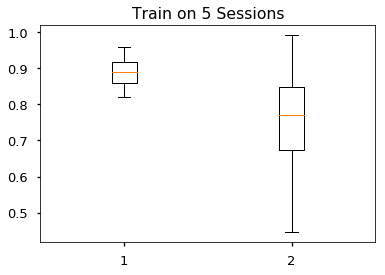

In [58]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

    
ax=plt.boxplot([day1_5.values, auroc2_5])
plt.title('Train on 5 Sessions from Day 1')

# Subgroup of tasks - Train and Test on subgroups of tasks (Just for reference, NOT USED in current version of the paper)

In [20]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB,taskC,taskD]


 ['Motor #4: Finger to Nose' 'Motor #5: Alternating Hand Movements']
Rows w Tremor 1333/3187 = 0.42
Training Random Forest

Subj/Visit 0, prec=0.757, rec=0.812, Spec=0.926, auroc_train=1.000, auroc=0.923

Subj/Visit 1, prec=0.768, rec=0.495, Spec=0.698, auroc_train=1.000, auroc=0.648

Subj/Visit 2, prec=0.802, rec=0.901, Spec=0.778, auroc_train=1.000, auroc=0.930

Subj/Visit 3, prec=0.562, rec=0.800, Spec=0.776, auroc_train=1.000, auroc=0.852

Subj/Visit 4, prec=0.775, rec=0.392, Spec=0.892, auroc_train=1.000, auroc=0.683

Subj/Visit 5, prec=0.717, rec=0.804, Spec=0.460, auroc_train=1.000, auroc=0.722

Subj/Visit 6, prec=0.949, rec=0.825, Spec=0.922, auroc_train=1.000, auroc=0.939

Subj/Visit 7, prec=0.521, rec=0.700, Spec=0.408, auroc_train=1.000, auroc=0.566

Subj/Visit 8, prec=0.894, rec=0.596, Spec=0.389, auroc_train=1.000, auroc=0.405

Subj/Visit 9, prec=0.758, rec=0.625, Spec=0.830, auroc_train=1.000, auroc=0.838

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.0

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.286, rec=0.833, Spec=0.781, auroc_train=1.000, auroc=0.875

Subj/Visit 17, prec=1.000, rec=0.328, Spec=1.000, auroc_train=1.000, auroc=0.751

Subj/Visit 18, prec=0.979, rec=0.354, Spec=0.958, auroc_train=1.000, auroc=0.747
f1_test=0.504+/-0.281, prec=0.570+/-0.336, rec=0.512+/-0.297, auprc=0.631+/-0.302, auroc=0.750+/-0.150

 ['Motor #2: Walking' 'Motor #3: Walking while Counting']
Rows w Tremor 895/6673 = 0.13
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.124


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.322, Spec=1.000, auroc_train=1.000, auroc=0.945


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.631, rec=0.745, Spec=0.932, auroc_train=1.000, auroc=0.950


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.997, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=1.000, rec=0.018, Spec=1.000, auroc_train=1.000, auroc=0.804

Subj/Visit 18, prec=0.992, rec=0.510, Spec=0.987, auroc_train=1.000, auroc=0.799
f1_test=0.099+/-0.226, prec=0.191+/-0.376, rec=0.084+/-0.203, auprc=0.678+/-0.362, auroc=0.709+/-0.282

 ['Motor #10: Drinking Water' 'Motor #11: Organizing Folder'
 'Motor #12: Folding Towels']
Rows w Tremor 3714/12167 = 0.31
Training Random Forest

Subj/Visit 0, prec=0.421, rec=0.232, Spec=0.935, auroc_train=1.000, auroc=0.707

Subj/Visit 1, prec=0.894, rec=0.063, Spec=0.952, auroc_train=1.000, auroc=0.531

Subj/Visit 2, prec=0.167, rec=0.087, Spec=0.938, auroc_train=1.000, auroc=0.555

Subj/Visit 3, prec=0.028, rec=0.042, Spec=0.948, auroc_train=1.000, auroc=0.509

Subj/Visit 4, prec=0.569, rec=0.120, Spec=0.947, auroc_train=1.000, auroc=0.587

Subj/Visit 5, prec=0.744, rec=0.450, Spec=0.780

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=nan

Subj/Visit 8, prec=1.000, rec=0.237, Spec=1.000, auroc_train=1.000, auroc=0.731


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.930, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.504


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.691, rec=0.506, Spec=0.748, auroc_train=1.000, auroc=0.672


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.913, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.365, rec=0.342, Spec=0.909, auroc_train=1.000, auroc=0.728


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.957, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.852, rec=0.176, Spec=0.821, auroc_train=1.000, auroc=0.430

Subj/Visit 18, prec=0.879, rec=0.269, Spec=0.867, auroc_train=1.000, auroc=0.624
f1_test=0.176+/-0.199, prec=0.348+/-0.376, rec=0.133+/-0.159, auprc=0.481+/-0.343, auroc=0.569+/-0.151

 ['Motor #7: Drawing on Paper' 'Motor #8: Typing on a Computer'
 'Motor #9: Nuts and Bolts']
Rows w Tremor 2227/10303 = 0.22
Training Random Forest

Subj/Visit 0, prec=0.241, rec=0.140, Spec=0.955, auroc_train=1.000, auroc=0.782

Subj/Visit 1, prec=0.905, rec=0.083, Spec=0.994, auroc_train=1.000, auroc=0.805

Subj/Visit 2, prec=1.000, rec=0.077, Spec=1.000, auroc_train=1.000, auroc=0.823


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.931, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.364, rec=0.019, Spec=0.982, auroc_train=1.000, auroc=0.667

Subj/Visit 5, prec=0.658, rec=0.200, Spec=0.922, auroc_train=1.000, auroc=0.676


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.807

Subj/Visit 8, prec=0.963, rec=0.270, Spec=0.980, auroc_train=1.000, auroc=0.845


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.952, auroc_train=1.000, auroc=0.418


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan

Subj/Visit 12, prec=0.699, rec=0.657, Spec=0.768, auroc_train=1.000, auroc=0.777


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.979, auroc_train=1.000, auroc=nan

Subj/Visit 14, prec=0.133, rec=0.051, Spec=0.967, auroc_train=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.986, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.968, rec=0.276, Spec=0.975, auroc_train=1.000, auroc=0.789

Subj/Visit 18, prec=0.915, rec=0.328, Spec=0.942, auroc_train=1.000, auroc=0.780
f1_test=0.153+/-0.204, prec=0.360+/-0.409, rec=0.111+/-0.167, auprc=0.501+/-0.320, auroc=0.730+/-0.119


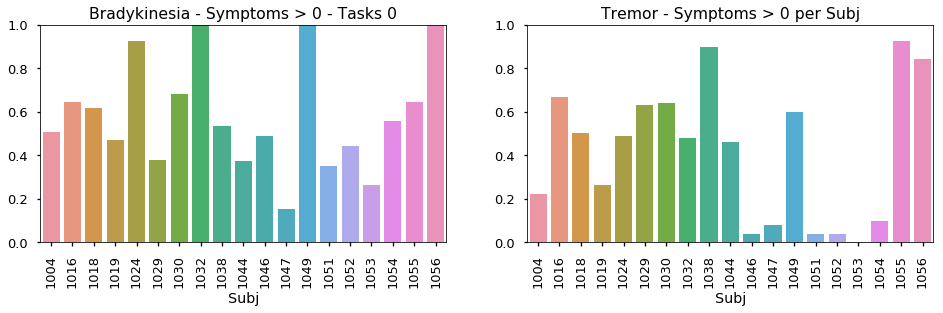

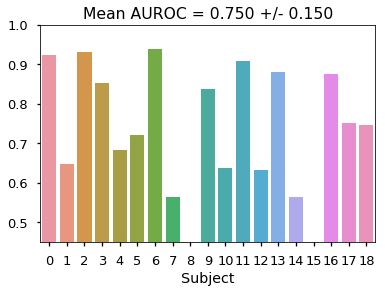

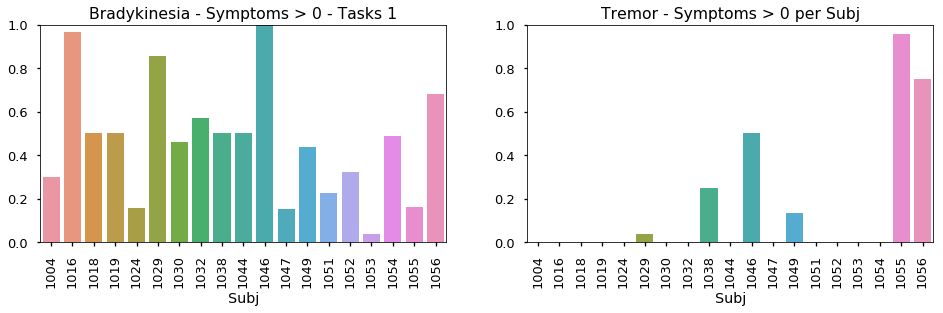

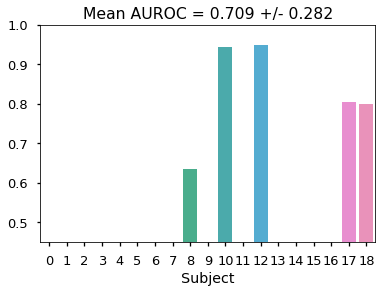

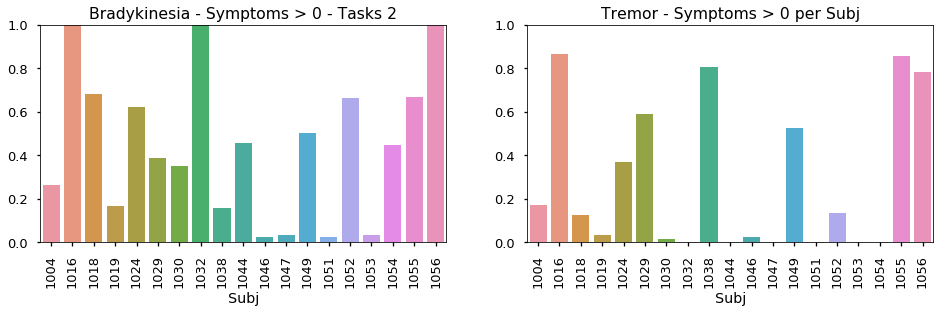

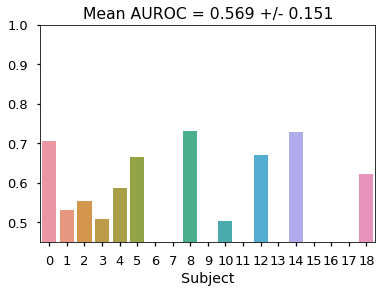

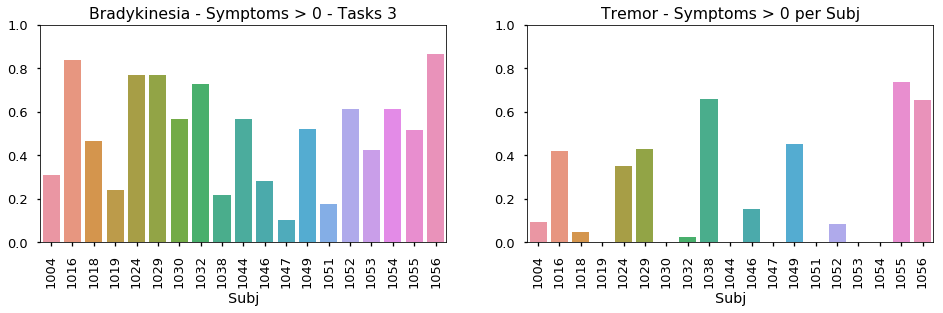

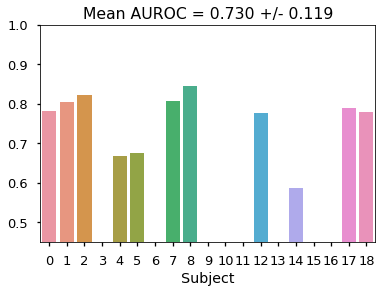

In [146]:
results_task = pd.DataFrame(data=[]) #sae auc for each subject and set of tasks

for i,T in enumerate(tasks): 
    #select group of tasks (A,B,..)
    Data=pd.DataFrame()
    for t in T:
        Data=pd.concat((Data,Dataorig[Dataorig.Task==t]))
    
    print('\n %s'%Data.Task.unique())
    
    #show symptoms per group of tasks
    BradP=[]; TremorP=[]; subjs = []
    for s in Data['Subject'].unique():
        d = Data.loc[Data['Subject']==s]
        BradP.append(sum(d['Bradykinesia'] > 0)/len(d['Bradykinesia']))
        TremorP.append(sum(d['Tremor'] > 0)/len(d['Tremor']))
        subjs.append(s)
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.title('Bradykinesia - Symptoms > 0 - Tasks %d'%(i)), plt.xlabel('Subj')
    plt.ylim([0,1])
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')
    ax=plt.xticks(np.arange(len(BradP)),subjs,rotation=90)
    plt.ylim([0,1])
    
    #train clf on subtasks
    res_all = pd.DataFrame()
    fnames = Data.iloc[:,7:].columns
    for symptom in ['Tremor']:
        
        #remove nan rows for current symptom
        Data=Data[~Data[symptom].isnull()]
        X = Data.iloc[:,7:].as_matrix()
        # X = StandardScaler().fit_transform(X)

        #use all data
        indp = ((Data[symptom]>0))
        indp = indp.values
        y = indp.astype(int) #target 
        groups = Data.Subject.as_matrix()

    #     #balance classes
    #     X = Data.iloc[np.hstack((indp_new,indn_new)),7:].as_matrix()  
    #     y = Data.iloc[np.hstack((indp_new,indn_new))][symptom]  
    #     y=(y>0).values.astype(int)
    #     groups=Data.iloc[np.hstack((indp_new,indn_new))]['Subject']

        print('Rows w %s %d/%d = %.2f'%(symptom,sum(y),len(y),(sum(y)/len(y))))
        models = [RandomForestClassifier(n_estimators=50,random_state=0)]#,GradientBoostingClassifier()]
                  #SVC(cache_size=800,probability=True)]          
        model_name = ['Random Forest']#,'GB']#,'SVM']#,'XGB']
        models = list(zip(models,model_name))
        res,res_group = LOSOCV(Data,X,y,groups,models)
        res_all = pd.concat((res_all,res))
        
        #plot results
        le = LabelEncoder()
        subj = le.fit_transform(np.unique(groups))
        aurocall = res_group['Random Forest']['auroc']
        plt.figure()
        ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
        plt.xlabel('Subject')
        plt.ylim([0.45,1.])
        plt.title('Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
        
        r = pd.DataFrame({i:res_group['Random Forest']['auroc']})
        results_task=pd.concat((results_task,r),axis=1)


results_task=results_task.rename(columns={0: "Structured", 1: "Walking", 2:'Gross',3:'Fine'})


In [155]:
results_task

,Structured,Walking,Gross,Fine
0,0.922903,NaN,0.707092,0.781829
1,0.647593,NaN,0.531026,0.804820
2,0.929889,NaN,0.555182,0.822650
3,0.852089,NaN,0.509034,NaN
4,0.682934,NaN,0.587154,0.667278
5,0.722296,0.123789,0.664273,0.676325
6,0.939076,NaN,0.152212,NaN
7,0.565590,NaN,NaN,0.807216
8,0.404558,0.636013,0.730609,0.844780
9,0.838497,NaN,NaN,NaN


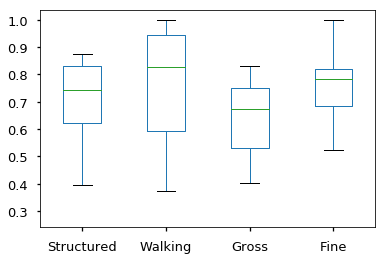

In [110]:
results_task.plot(kind='box')
plt.title('Tremor')

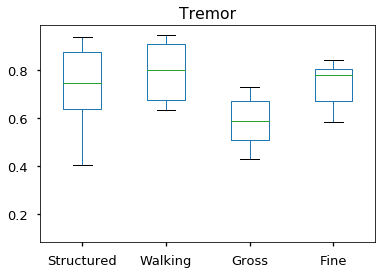

In [147]:
results_task.plot(kind='box')
plt.title('Tremor')